In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
import pandas as pd
import random
import cv2
import plotly.express as px

In [9]:
def load_images_from_folder(folder_path, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)
        
        if os.path.isdir(full_path) or filename.startswith('.'):
            continue
        try:
            img = cv2.imread(full_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
        except Exception as e:
            print(f"Error al cargar {filename}: {e}")
    return np.array(images)

In [15]:
base_path = 'c:/Users/qdari/OneDrive/Documentos/aprendizajeSupervisado/planttraits2024'  ###
X = load_images_from_folder(os.path.join(base_path, 'images_original'))
Y = load_images_from_folder(os.path.join(base_path, 'images_clean'))
X_test = load_images_from_folder(os.path.join(base_path, 'images_test'))

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

X_train = X_train.astype('float32') / 255.0
Y_train = Y_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
Y_val = Y_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f'Train shape: {X_train.shape}, Validation shape: {X_val.shape}')

Train shape: (320, 256, 256, 3), Validation shape: (80, 256, 256, 3)


In [16]:
def compute_ssim(y_true, y_pred):
    return ssim((y_true * 255).astype('uint8'), (y_pred * 255).astype('uint8'), channel_axis=2)

def psnr(img1, img2):
    return cv2.PSNR((img1 * 255).astype(np.uint8), (img2 * 255).astype(np.uint8))


In [21]:
#results = []

optimizer_class = 'Adam'
lr = 5e-5
batch_size = 16
base_filters = 64
optimizer = Adam(learning_rate=lr)

input_img = Input(shape=(256,256, 3))
x = Conv2D(base_filters, (3, 3), padding='same')(input_img)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(base_filters*8, (3, 3), padding='same')(encoded)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*4, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters*2, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(base_filters, (3, 3), padding='same')(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), padding='same')(x)
decoded = LeakyReLU(negative_slope=0.01)(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=optimizer_class, loss='mse')

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoder.fit(
    X_train, Y_train,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, Y_val),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.3702 - val_loss: 0.0632
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - loss: 0.0613 - val_loss: 0.0659
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - loss: 0.0613 - val_loss: 0.0627
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - loss: 0.0598 - val_loss: 0.0605
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.0575 - val_loss: 0.0552
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 0.0504 - val_loss: 0.0525
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.0503 - val_loss: 0.0520
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 0.0501 - val_loss: 0.0467
Epoch 9/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.0519 - val_loss: 0.0488
Epoch 10/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - loss: 0.0525 - val_loss: 0.0494
Epoch 11/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.0466 - val_loss: 0.0461
Epoch 12/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - loss: 0.0469 - val_lo

In [40]:
Y_pred = autoencoder.predict(Y_val, verbose=0)
Y_pred = (Y_pred -Y_pred.min()) / (Y_pred.max() - Y_pred.min())

mse = np.mean([mean_squared_error(y.flatten(), yp.flatten()) for y, yp in zip(Y_val, Y_pred)])
psnr_val = np.mean([psnr(y, yp) for y, yp in zip(Y_val, Y_pred)])
ssim_val = np.mean([compute_ssim(y, yp) for y, yp in zip(Y_val, Y_pred)])

results.append({
    'trial': 4,
    'optimizer': optimizer_class,
    'learning_rate': lr,
    'batch_size': batch_size,
    'filters': base_filters,
    'MSE': mse,
    'PSNR': psnr_val,
    'SSIM': ssim_val,
    'AF' : 'LR'
})

In [41]:
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='PSNR', ascending=False))

   trial optimizer  learning_rate  batch_size  filters       MSE       PSNR  \
1      4      Adam        0.00005          16       64  0.039642  15.571421   
0      4      Adam        0.00005          16       64  0.042227  14.882272   

       SSIM  AF  
1  0.598542  LR  
0  0.598412  LR  


In [26]:
augmenter = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = augmenter.flow(X_train, batch_size=batch_size)
target_generator = augmenter.flow(Y_train, batch_size=batch_size)

def combined_generator(gen1, gen2):
    while True:
        yield next(gen1), next(gen2)

augmented_data = combined_generator(train_generator, target_generator)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

autoencoderAG = Model(input_img, decoded)
autoencoderAG.compile(optimizer=optimizer_class, loss='mse')

autoencoderAG.fit(
    augmented_data,
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, Y_val),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.0604 - val_loss: 0.0622
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 0.0609 - val_loss: 0.0627
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 0.0660 - val_loss: 0.0622
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - loss: 0.0617 - val_loss: 0.0614
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - loss: 0.0585 - val_loss: 0.0607
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.0604 - val_loss: 0.0626
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - loss: 0.0622 - val_loss: 0.0622
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - loss: 0.0626 - val_loss: 0.0625
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.0620 - val_loss: 0.0622
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - loss: 0.0649 - val_loss: 0.0620


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step    


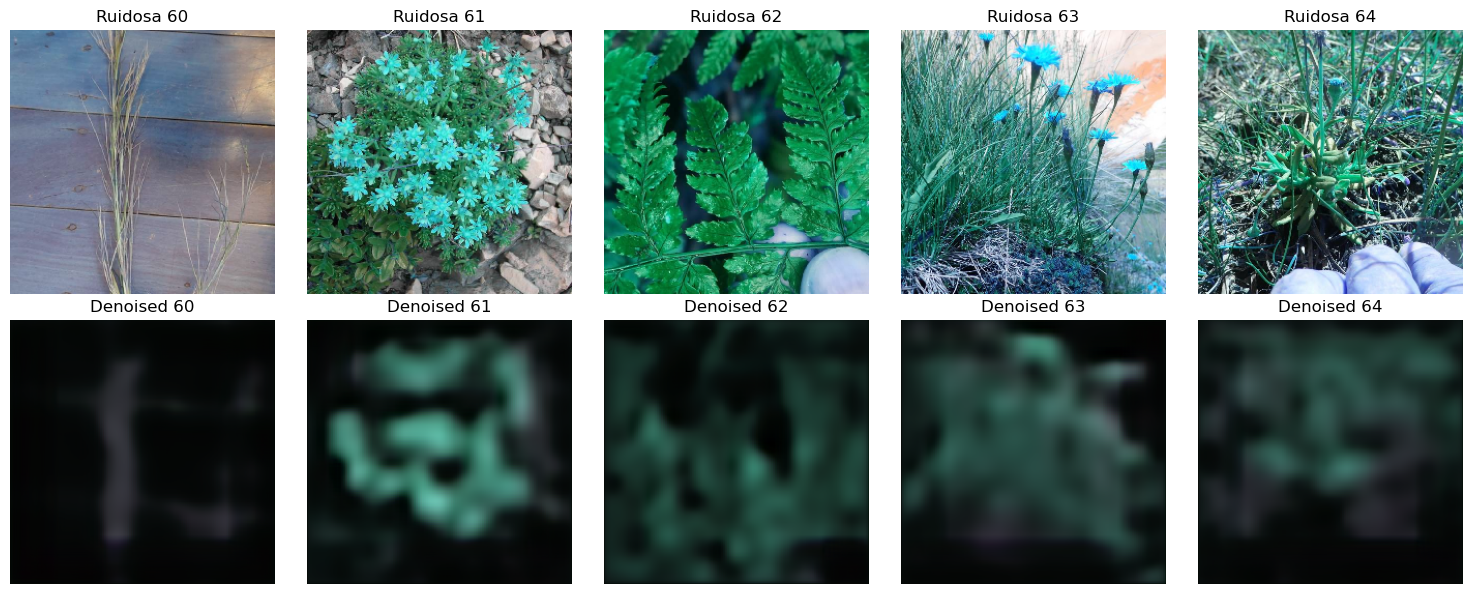

In [45]:
start_index = 10

X_test = load_images_from_folder(os.path.join(base_path, 'images_test'))
X_test = X_test.astype('float32') / 255.0
X_denoised = autoencoder.predict(X_test)
X_denoised = (X_denoised - X_denoised.min()) / (X_denoised.max() - X_denoised.min())

# Mostrar comparativa: ruidosa vs reconstruida
n = 5  # número de imágenes a mostrar
plt.figure(figsize=(15, 6))
for i in range(n):
    idx = start_index + i
    if idx >= len(X_test):
        break
    ax = plt.subplot(2, n, i + 1)  # Imagen ruidosa
    plt.imshow(X_test[idx])
    plt.title(f"Ruidosa {idx}")
    plt.axis("off")
    ax = plt.subplot(2, n, i + 1 + n)  # Imagen denoised
    plt.imshow(X_denoised[idx])
    plt.title(f"Denoised {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()


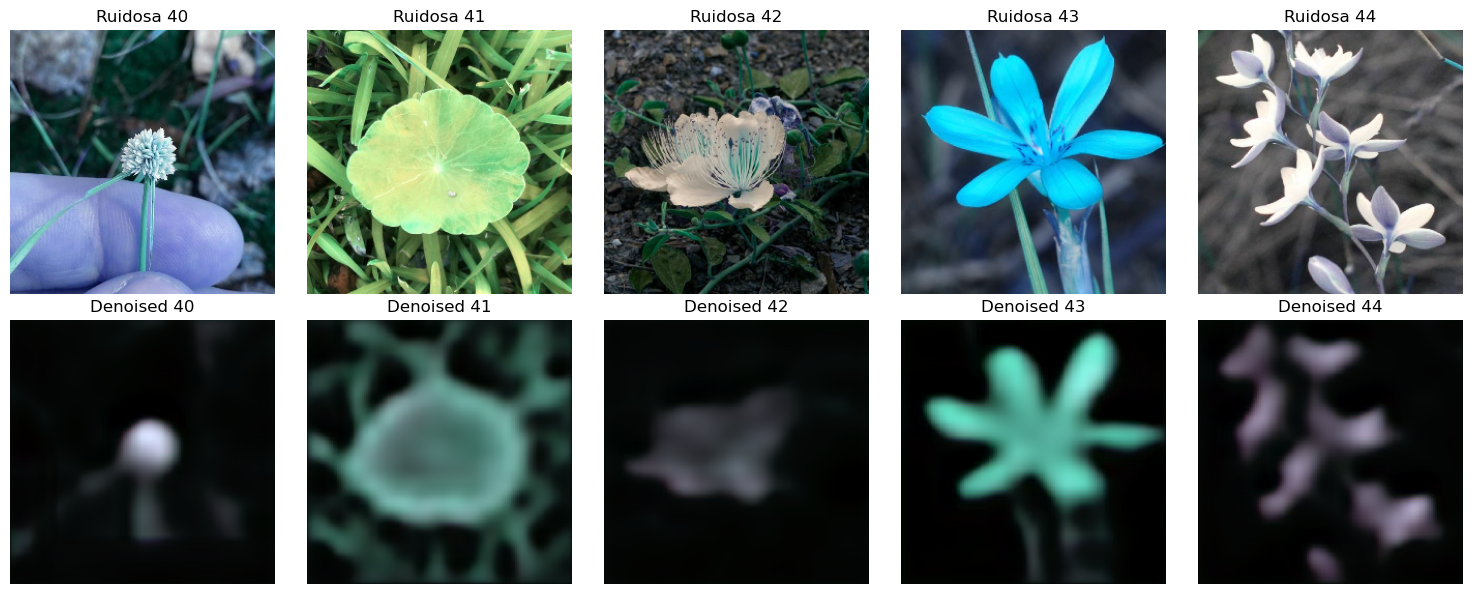

In [44]:

start_index = 40

n = 5  # número de imágenes a mostrar
plt.figure(figsize=(15, 6))
for i in range(n):
    idx = start_index + i
    if idx >= len(Y_pred):
        break
    ax = plt.subplot(2, n, i + 1)  # Imagen ruidosa
    plt.imshow(X_val[idx])
    plt.title(f"Ruidosa {idx}")
    plt.axis("off")
    ax = plt.subplot(2, n, i + 1 + n)  # Imagen denoised
    plt.imshow(Y_pred[idx])
    plt.title(f"Denoised {idx}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [27]:
Y_pred = autoencoder.predict(Y, verbose=0)

mse = np.mean([mean_squared_error(y.flatten(), yp.flatten()) for y, yp in zip(Y, Y_pred)])
psnr_val = np.mean([psnr(y, yp) for y, yp in zip(Y, Y_pred)])
ssim_val = np.mean([compute_ssim(y, yp) for y, yp in zip(Y, Y_pred)])

results.append({
    'trial': 1,
    'optimizer': optimizer_class,
    'learning_rate': lr,
    'batch_size': batch_size,
    'filters': base_filters,
    'MSE': mse,
    'PSNR': psnr_val,
    'SSIM': ssim_val,
    'AF' : 'sigmoid'
})

In [28]:
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='PSNR', ascending=False))

   trial optimizer  learning_rate  batch_size  filters       MSE       PSNR  \
0      1      Adam        0.00005          16       64  0.054156  13.323993   
1      1      Adam        0.00005          16       64  0.056345  13.148245   

       SSIM       AF  
0  0.056475  sigmoid  
1  0.053172  sigmoid  
